
# 02 | Testing (Roughly) Simulated Data


In this notebook we generate a composition of sinusoidal waves perturbed by random noise and attempt to perform:

- Confound cleaning using one of the sinusoidal terms implicit in the model
- Implement a fake FD trace to perform censoring and interpolation with
- Perform end-to-end cleaning of data

We'll need to evaluate the following criteria using simulated data:

1. The base censoring method, are islands of continguous time-points removed?
 - Implemented, use _get_censor_mask to obtain temporal mask
2. Interpolation methods, do interpolations produce reasonable estimates of the data
3. Discrete basis methods, do the design matrices produce the correct frequencies to regress?

First we need to simulate a sinusoidal wave function

In [70]:
import nilearn.image as nimg
import numpy as np
import importlib
import pandas as pd
import copy
import confounds.designs as designs
import confounds.spectral_interpolation as spectral_interp
from confounds import censor_method
import seaborn as sns
import matplotlib.pyplot as plt
import nibabel as nib

Next we need to test that interpolation steps present in our workflows function as expected.

In [71]:
# Pull real nuisance data
conf = '../data/debugging_data/sub-LA1LA10056_ses-01_task-rest_run-1_desc-confounds_timeseries.tsv'
conf_df = pd.read_csv(conf, delimiter="\t")
base_cols = [
    "trans_x", "trans_y", "trans_z",
    "rot_x", "rot_y", "rot_z",
    "csf", "white_matter", "global_signal"
]

sq = True
deriv = True
sqderiv = True

all_cols = copy.copy(base_cols)
if sq:
    all_cols += [f"{f}_power2" for f in base_cols]
    
if deriv:
    all_cols += [f"{f}_derivative1" for f in base_cols]
    
if sqderiv:
    all_cols += [f"{f}_derivative1_power2" for f in base_cols]
    
# Drop first row to handle NaNs
regressor_df = conf_df.loc[1:, all_cols]
fd = conf_df.loc[1:, 'framewise_displacement']

In [72]:
np.random.seed(seed=1)

# Set constants
TR = 0.8
N = regressor_df.shape[0] + 10

# Basis functions and weights
ws = np.array([0.001, 0.003, 0.007,
               0.01, 0.04, 0.06, 0.08,
               0.1, 0.3, 0.6])
w_ws = np.random.uniform(size=ws.shape[0] * 2)

# Implement random phase shifts
w_phi = np.random.uniform(size=ws.shape)

# Construct basis signal
t = np.arange(N) * TR
X = designs.shifted_fourier(t[:, np.newaxis], ws, w_phi) \
    @ w_ws[:, np.newaxis]
t = t[10:]
X = X[10:]

Next we want to simulate confound regressors.

To keep the model parsimonious and to avoid over-complicating our simulation we'll pull some sample regressors from real subject data. Then we will pollute our data with a noisier version of the estimated real confounds.

This way we can simulate dynamics of real nuisance regressors but still have a ground-truth available to compare against.

In [73]:
# Generate random weights for each confound regressor
w_regr = np.random.uniform(size=(1,regressor_df.shape[1]))
regressor_df = regressor_df\
            .apply(lambda x: spectral_interp.normalize_variance_on(x, X),
             axis=0)\
            .reset_index(drop=True)

# Pollute data with noisy nuisance regressors
X_final = X \
    + ((regressor_df.to_numpy() * np.random.normal(size=w_regr.shape)) \
    @ w_regr.T)

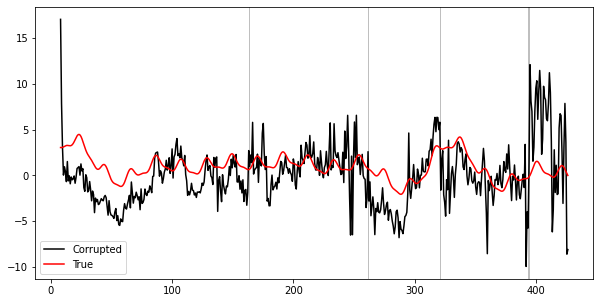

In [74]:
f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)
sns.lineplot(x=t, y=X_final.flatten() - X_final.mean(), ax=ax,
            color="k")
sns.lineplot(x=t, y=X.flatten(), ax=ax, color='r')

# Mark thresholds
fd_mask = np.where(fd > 0.5)[0]
for i in np.arange(len(fd_mask) - 1):
    plt.axvspan(t[fd_mask[i]], t[fd_mask[i] + 1],
               facecolor='grey', alpha=0.5)
    
plt.legend(labels=["Corrupted","True"])

Now that we have our fake signal we can start testing whether our censoring and interpolation strategies are working as expected!

In [75]:
X_final.shape

(524, 1)

In [76]:
clean_dict = {
    "--cf-cols": ','.join(all_cols),
    "detrend": True, "standardize": True,
    "low_pass": 0.08,
    "high_pass": 0.009
}

data = nib.Nifti1Image(X_final.T[np.newaxis,np.newaxis,:],
                       affine=np.eye(4))
confounds = regressor_df
confounds['framewise_displacement'] = fd

In [77]:
# Set up base cleaning variable to use some functions
baseclean = censor_method.BaseClean(clean_dict)

In [78]:
# Set up variables for visualization
nonsteady_data, nonsteady_conf  = censor_method.\
                                    _clear_steady_state(data,
                                                        confounds,
                                                        drop_trs=5)


mask, censor = baseclean.\
                _get_censor_mask(nonsteady_conf['framewise_displacement'],
                                                    fd_thres=0.5)
nonsteady_sgl = nonsteady_data.get_fdata().flatten()


t = np.arange(data.shape[-1]) * TR
t = t[5:]

# Get a steady-state cleared version of true data as well
nonsteady_true = X[5:, :].flatten()

`BaseClean` result on simulation data

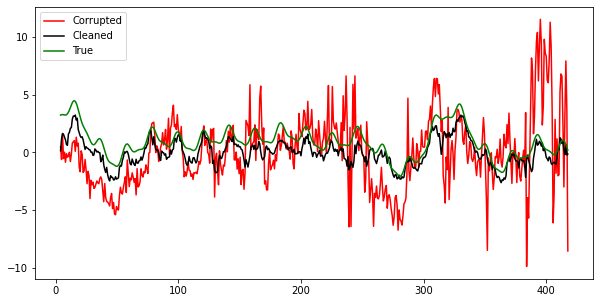

In [79]:
baseclean = censor_method.BaseClean(clean_dict)
res = baseclean.transform(data, regressor_df, drop_trs=5)
res = res.get_fdata().flatten()
# Visualize
f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)

sns.lineplot(x=t[mask], y=nonsteady_sgl[mask] - nonsteady_sgl[mask].mean(),
             ax=ax, color='r')

sns.lineplot(x=t[mask], y=res, ax=ax, color='k')
sns.lineplot(x=t[mask], y=nonsteady_true[mask], color='g')
plt.legend(["Corrupted", "Cleaned", "True"])

`PowersClean` result on simulation data

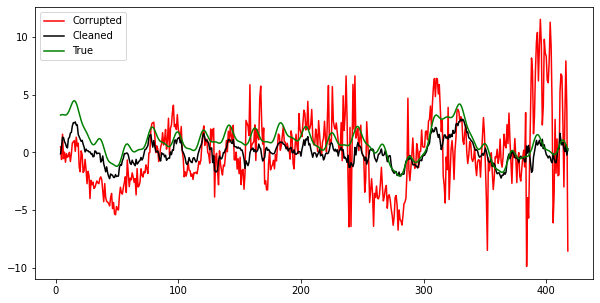

In [80]:
powersclean = censor_method.PowersClean(clean_dict)
res = powersclean.transform(data, regressor_df, drop_trs=5)
res = res.get_fdata().flatten()

f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)

sns.lineplot(x=t[mask],
             y=nonsteady_sgl[mask] - nonsteady_sgl[mask].mean(), color='r')
sns.lineplot(x=t[mask],y=res, ax=ax, color='k')
sns.lineplot(x=t[mask],
             y=nonsteady_true[mask], color='g')
plt.legend(["Corrupted", "Cleaned", "True"])

`LindquistPowersClean` result on simulation data

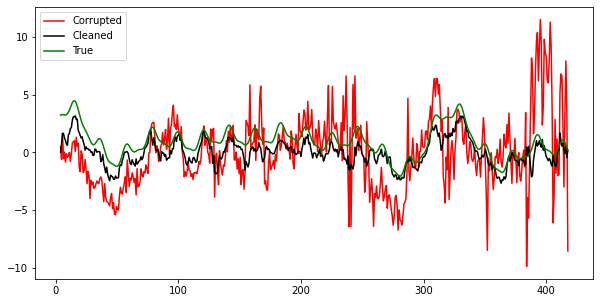

In [81]:
lindpowersclean = censor_method.LindquistPowersClean(clean_dict)
res = lindpowersclean.transform(data, regressor_df, drop_trs=5)
res = res.get_fdata().flatten()

f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)

sns.lineplot(x=t[mask],
             y=nonsteady_sgl[mask] - nonsteady_sgl[mask].mean(), color='r')
sns.lineplot(x=t[mask],y=res, ax=ax, color='k')
sns.lineplot(x=t[mask],
             y=nonsteady_true[mask], color='g')
plt.legend(["Corrupted", "Cleaned", "True"])

`DCTBasisClean` result on simulation data

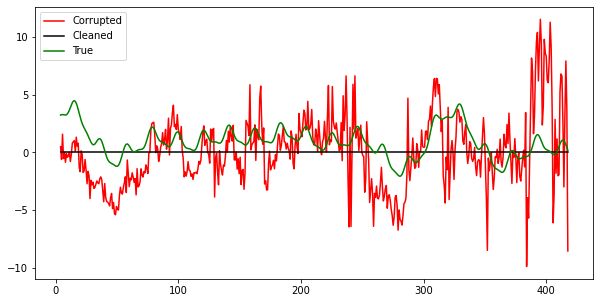

In [82]:
dctclean = censor_method.DCTBasisClean(clean_dict)
res = dctclean.transform(data, regressor_df, drop_trs=5)
res = res.get_fdata().flatten()

f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)

sns.lineplot(x=t[mask],
             y=nonsteady_sgl[mask] - nonsteady_sgl[mask].mean(), color='r')
sns.lineplot(x=t[mask],y=res, ax=ax, color='k')
sns.lineplot(x=t[mask],
             y=nonsteady_true[mask], color='g')
plt.legend(["Corrupted", "Cleaned", "True"])

`FourierBasisClean` on simulation data

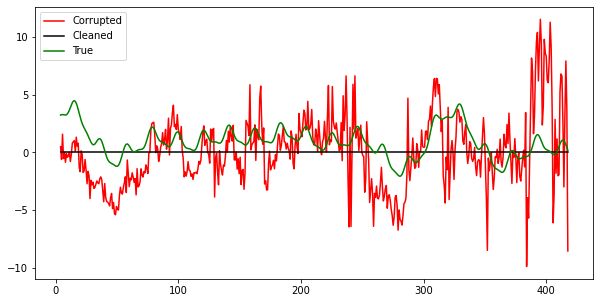

In [84]:
fourierclean = censor_method.FourierBasisClean(clean_dict)
res = fourierclean.transform(data, regressor_df, drop_trs=5)
res = res.get_fdata().flatten()

f = plt.figure(figsize=(10, 5))
ax = f.add_subplot(111)

sns.lineplot(x=t[mask],
             y=nonsteady_sgl[mask] - nonsteady_sgl[mask].mean(), color='r')
sns.lineplot(x=t[mask],y=res, ax=ax, color='k')
sns.lineplot(x=t[mask],
             y=nonsteady_true[mask], color='g')
plt.legend(["Corrupted", "Cleaned", "True"])

In [85]:
# Both DCT and fourier fail spectacularly